In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mt
import scipy.optimize as spo

In [2]:
# ----------- convenciones ------------------
dias_mes=30
dia_año=360
dia_prestamo=365
#================== caracteristicas de los contratos en días ===================

plazos_tasas=[3*dias_mes,6*dias_mes,12*dias_mes,2*dia_año,3*dia_año,5*dia_año,7*dia_año,10*dia_año]
plazo_curva=[0,3*dias_mes,dia_año,3*dia_año,5*dia_año,10*dia_año]

# Abrir datos

In [3]:
datos=pd.read_excel("datos_taller.xlsx", index_col=0)/100

In [4]:
datos.tail()

,ICE LIBOR USD 3 Month,ICE LIBOR USD 6 Month,ICE LIBOR USD 12 Month,USD SWAP SEMI 30/360 2YR,USD SWAP SEMI 30/360 3YR,USD SWAP SEMI 30/360 5YR,USD SWAP SEMI 30/360 7YR,USD SWAP SEMI 30/360 10Y
Dates,,,,,,,,
2020-02-06,0.017341,0.017496,0.018426,0.015046,0.014624,0.014704,0.015168,0.016031
2020-02-07,0.017309,0.017404,0.018349,0.014552,0.014089,0.014129,0.014561,0.015400
2020-02-10,0.017131,0.017206,0.018005,0.014313,0.013850,0.013891,0.014329,0.015169
2020-02-11,0.017073,0.017245,0.018071,0.014561,0.014129,0.014172,0.014630,0.015473
2020-02-12,0.017037,0.017254,0.018127,0.014890,0.014509,0.014585,0.015051,0.015894


Asignar a cada prestamo los dias de duración

In [5]:
plazos={}
for i in range(len(datos.columns)):
    plazos[datos.columns[i]]=plazos_tasas[i]
plazos

{'ICE LIBOR USD 3 Month': 90,
 'ICE LIBOR USD 6 Month': 180,
 'ICE LIBOR USD 12 Month': 360,
 'USD SWAP SEMI 30/360 2YR': 720,
 'USD SWAP SEMI 30/360 3YR': 1080,
 'USD SWAP SEMI 30/360 5YR': 1800,
 'USD SWAP SEMI 30/360 7YR': 2520,
 'USD SWAP SEMI 30/360 10Y': 3600}

In [6]:
tipo={}
instrumento=["libor","libor","libor","swap","swap","swap","swap","swap"]
for i in range(len(datos.columns)):
    tipo[i]=instrumento[i]
tipo

{0: 'libor',
 1: 'libor',
 2: 'libor',
 3: 'swap',
 4: 'swap',
 5: 'swap',
 6: 'swap',
 7: 'swap'}

In [17]:
nombre={}
for i in range(len(datos.columns)):
    nombre[i]=datos.columns[i]
nombre

{0: 'ICE LIBOR USD 3 Month',
 1: 'ICE LIBOR USD 6 Month',
 2: 'ICE LIBOR USD 12 Month',
 3: 'USD SWAP SEMI 30/360 2YR',
 4: 'USD SWAP SEMI 30/360 3YR',
 5: 'USD SWAP SEMI 30/360 5YR',
 6: 'USD SWAP SEMI 30/360 7YR',
 7: 'USD SWAP SEMI 30/360 10Y'}

# Curva forward

In [18]:
def intervalo(df):
    # Esta función tiene el objetivo de crear un intervalo en forma de vector
    # Me devuelve un array de nx2
    x=np.array([np.array(df[i:i+2]) for i in range(len(df)-1)])
    return x

[0, 90, 360, 1080, 1800, 3600] 6


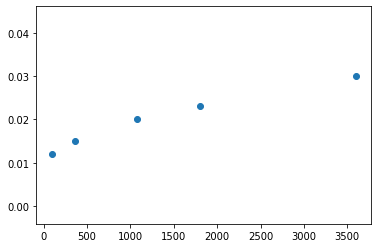

In [19]:
#=================== Aplico esta función al plazo que tengo para la curva =======================
plazo_curva=[0,3*dias_mes,dia_año,3*dia_año,5*dia_año,10*dia_año]
intervalo_curva=intervalo(plazo_curva)

print(plazo_curva,len(plazo_curva))

# ====================== Gráfico la curva con los valores iniciales ======================
tasas_curva=[0.012,0.015,0.02,0.023,0.03]
plt.scatter(plazo_curva[1:],tasas_curva)

In [20]:
# ========================== Veo como está el intervalo ===================================
intervalo_curva

array([[   0,   90],
       [  90,  360],
       [ 360, 1080],
       [1080, 1800],
       [1800, 3600]])

### Funciones para la creación de los plazos de la curva a la medidad del instrumento y el DF

In [21]:
def plazo_curva_fw(plazo_instrumento, plazos_curva):
    #plazo_instrumento: plazo de vencicimiento del instrumento
    #plazo_curva: plazos de la curva forward
    
    # Con esta fórmula construyo la base de plazos, teniendo en cuenta la duración del instrumento
    # lo que intento hacer es encontrar el mínimo entre los plazos
    # de esta manera si el venciemiento es menor al plazo tomo como referencia el plazo
    nuevos_plazos=[]
    for plazo in plazos_curva:
        nuevos_plazos=np.append(nuevos_plazos,min(plazo,plazo_instrumento))
    
    return intervalo(nuevos_plazos)
    
def DF(tasas_forwards, plazos):
    #tasa_forwards: tasas de la curva
    #plazos: plazos de a los que quiero valorar cada instrumento
    #tipo: tipo de crédito swap o libor
    
    #=========== Esto solo sirve para libor ===============================
    
    #con esta fórmula encuentro el factor de descuente para cada fecha
    #el factor se inicia en cero porque es el tiempo t=1
    # la fórmila sirve tanto para sacar los factores de descuento de libor y swaps
    # deja como variables las tasas forwards
    factor_d=[]
   
    for i in range(len(tasas_forwards)):
        periodo=(plazos[i][1]-plazos[i][0])/dia_año
        if periodo==0:
            FD_1=1
            factor_d=np.append(factor_d,FD_1)
        else:
            FD_1=np.exp(-tasas_forwards[i]*(periodo))#FD_1=mt.exp(-tasas_forwards[i])
            factor_d=np.append(factor_d,FD_1)
                
    return factor_d

In [22]:
#verificar que hace formula
plazo_curva_fw(1500,plazo_curva)

array([[   0.,   90.],
       [  90.,  360.],
       [ 360., 1080.],
       [1080., 1500.],
       [1500., 1500.]])

In [23]:
años=7
2*(años*360/360)

14.0

In [24]:
#verificar que hace la formula de los factores
DF(tasas_curva,plazo_curva_fw(2*360,plazo_curva))

array([0.9970045 , 0.98881304, 0.98019867, 1.        , 1.        ])

# Fórmulas de valoración

In [25]:
def libor(tasa,tipo_libor,tasas_curva):
    # Con esta formula puedo saber cuanto se debe pagar al final del periodo con un crédito Libor
    #tasa: tasa libor para el periodo t
    # tipo libor: tipo de contrato
    # plazo curva: plazos de las curva forward
    global plazo_curva
    tipo=tipo_libor
    plazo_dias=plazos[tipo]
    vf_libor=100*(1+tasa*(plazo_dias/360))
    vp_libor=vf_libor*DF(tasas_curva,plazo_curva_fw(plazo_dias,plazo_curva)).prod()
    return vp_libor

def fd_swaps(plazo_vencimiento,tasas_curva):
    # plazo vencimiento: plazo en el que vence el contrato 
    # con esta fórmula puedo sacar el valor presente de un crédito libor o un crédito diferente
    # para cada factor de descuento
    global plazo_curva
    factor=0
    factor_final=0
    for i in range(int(plazo_vencimiento/360)*2):
        fd=DF(tasas_curva,plazo_curva_fw((i+1)*6*30,plazo_curva)).prod()
        factor+=fd
        factor_final=fd
    return factor,factor_final

def swap(cupon,tipo_swap,tasas_curva):
    # cupon: valor en % del cupon. Dejarlo expresado en decimales
    # Tipo de swap es el nombre del swap segun bloomberg
    tipo=tipo_swap
    plazo_dias=plazos[tipo]
    fd=fd_swaps(plazo_dias,tasas_curva)
    vp_swap=100*(1/2)*cupon*fd[0]+100*fd[1]
    return vp_swap

In [26]:
tasas_curva=[0.015,0.015,0.02,0.023,0.03]
plazo_curva=[0,3*dias_mes,dia_año,3*dia_año,5*dia_año,10*dia_año]

fd_swaps(2*360,tasas_curva)

(3.9185553227081, 0.9656054162575665)

In [27]:
instrumento=4
swap(datos.iloc[500][instrumento],nombre[instrumento],tasas_curva)

99.35191346096408

In [28]:
instrumento=0
libor(datos.iloc[500][instrumento],nombre[instrumento],tasas_curva)
#libor(datos.iloc[0][datos.columns[columna]],datos.columns[columna],tasas_curva)[0]

100.0988321788154

In [29]:
np.array(datos.iloc[0])

array([0.0172152, 0.0188769, 0.0217313, 0.021946 , 0.022975 , 0.023949 ,
       0.024604 , 0.025405 ])

# Metodo de calibración

### Función de evaluación 

In [30]:
def error_cuadrado(tasas_curva,datos):
    # función a optimizar
    # tasa_curva: son las tasas que se quieren encontrar
    # datos es el dato para una fecha específica
    global plazo_curva
    global tipo
    error_cuadrado=0
    for instrumento in range(len(datos)):
        if tipo[instrumento]=="libor":
            error=100-libor(datos[instrumento],nombre[instrumento],tasas_curva)
            error_cuadrado+=error**2
        else:
            error=100-swap(datos[instrumento],nombre[instrumento],tasas_curva)
            error_cuadrado=+error**2
    return error_cuadrado

### Optimizador

In [31]:
tasas_iniciales=[0.015,0.015,0.02,0.023,0.03]
plazo_curva=[0,3*dias_mes,dia_año,3*dia_año,5*dia_año,10*dia_año]

def optimizador(datos,error_cuadrado):
    global plazo_curva
    global tasas_iniciales
    # Encuentre el mínimo error posible, bajo las tasas de la cuerva forward
    result=spo.minimize(error_cuadrado,tasas_iniciales,args=(datos,),method="SLSQP",options={"disp":True})
    return result

In [32]:
#================ Prueba del optimizador =====================================
result=optimizador(datos.iloc[300],error_cuadrado)
result.x

/Users/armandomejiagarces/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/Users/armandomejiagarces/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:42: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/Users/armandomejiagarces/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp
/Users/armandomejiagarces/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:42: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/Users/armandomejiagarces/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.74927490261076e-08
            Iterations: 9
            Function evaluations: 80
            Gradient evaluations: 9


array([-0.05407522, -0.17828066, -0.2819842 ,  0.04006351,  0.2168627 ])

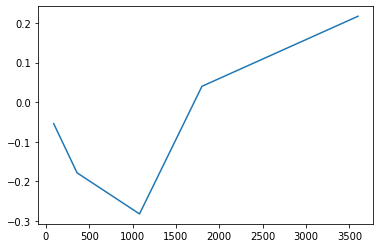

In [35]:
plt.plot(plazo_curva[1:],result.x)

In [36]:
tasa_fwrd=[]
for fecha in datos.index:
    tasa_fwrd=np.append(optimizador(datos.loc[fecha],error_cuadrado).x,tasa_fwrd)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.7361957219098635e-09
            Iterations: 3
            Function evaluations: 30
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.1952560534424438e-09
            Iterations: 3
            Function evaluations: 30
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.537574149411698e-11
            Iterations: 3
            Function evaluations: 30
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.838568320715188e-11
            Iterations: 5
            Function evaluations: 46
            Gradient evaluations: 5


/Users/armandomejiagarces/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/Users/armandomejiagarces/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1356006932106725e-07
            Iterations: 7
            Function evaluations: 65
            Gradient evaluations: 7


/Users/armandomejiagarces/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1981973036187159e-08
            Iterations: 12
            Function evaluations: 116
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.4805753458408074e-07
            Iterations: 14
            Function evaluations: 142
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.487697283606298e-08
            Iterations: 7
            Function evaluations: 66
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.310118200847384e-09
            Iterations: 12
            Function evaluations: 113
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3972437941640234e-07
            Iterations: 7
 

/Users/armandomejiagarces/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in double_scalars


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.294628018775393e-07
            Iterations: 11
            Function evaluations: 114
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.697830719007509e-09
            Iterations: 11
            Function evaluations: 106
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.8505719264409245e-10
            Iterations: 14
            Function evaluations: 128
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.96402502868121e-09
            Iterations: 12
            Function evaluations: 110
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.6187106936263324e-08
            Iterations: 10

/Users/armandomejiagarces/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.84883001751895e-11
            Iterations: 16
            Function evaluations: 176
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.444074577327003e-09
            Iterations: 18
            Function evaluations: 194
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.5159964363718e-07
            Iterations: 14
            Function evaluations: 164
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1704785322686459e-07
            Iterations: 14
            Function evaluations: 142
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.4988043411841717e-10
            Iterations: 10
 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.240658542710458e-10
            Iterations: 11
            Function evaluations: 109
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.693601459822609e-07
            Iterations: 12
            Function evaluations: 129
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2284460067043666e-10
            Iterations: 13
            Function evaluations: 135
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.4057788184546805e-08
            Iterations: 15
            Function evaluations: 145
            Gradient evaluations: 15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.82938237169033e-12
            Iterations: 12

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.3737196605776487e-09
            Iterations: 14
            Function evaluations: 141
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.969758769215839e-10
            Iterations: 13
            Function evaluations: 125
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.7116861166314564e-10
            Iterations: 15
            Function evaluations: 152
            Gradient evaluations: 15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.74971087453816e-08
            Iterations: 10
            Function evaluations: 103
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.0256659566440436e-11
            Iterations: 1

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.719478634072196e-09
            Iterations: 13
            Function evaluations: 125
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.149709826072719e-09
            Iterations: 15
            Function evaluations: 142
            Gradient evaluations: 15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1469046224166257e-08
            Iterations: 16
            Function evaluations: 159
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0958824972406681e-07
            Iterations: 19
            Function evaluations: 197
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.267330583921881e-09
            Iterations: 1

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.125200790350562e-11
            Iterations: 13
            Function evaluations: 127
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.74971087453816e-08
            Iterations: 10
            Function evaluations: 103
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.423741376422284e-09
            Iterations: 15
            Function evaluations: 146
            Gradient evaluations: 15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.81247877803746e-11
            Iterations: 13
            Function evaluations: 132
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.884591025700486e-09
            Iterations: 15
  

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.257098158385854e-07
            Iterations: 8
            Function evaluations: 71
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.093999585923936e-08
            Iterations: 13
            Function evaluations: 128
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2641923599752894e-10
            Iterations: 11
            Function evaluations: 107
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.575840737747275e-08
            Iterations: 11
            Function evaluations: 102
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.504425616925337e-08
            Iterations: 9
   

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.4114148835023852e-07
            Iterations: 6
            Function evaluations: 49
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.47327930922561e-09
            Iterations: 5
            Function evaluations: 46
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.109369068639526e-08
            Iterations: 4
            Function evaluations: 34
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.5517932593680915e-12
            Iterations: 3
            Function evaluations: 27
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.419623825066253e-09
            Iterations: 3
            

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.853053542825929e-07
            Iterations: 5
            Function evaluations: 42
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.3264556879378984e-09
            Iterations: 7
            Function evaluations: 56
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.5739986458983616e-07
            Iterations: 5
            Function evaluations: 46
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.324762629818265e-08
            Iterations: 6
            Function evaluations: 53
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.341042908311459e-08
            Iterations: 5
           

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.8316347618187285e-09
            Iterations: 8
            Function evaluations: 66
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.836515779636116e-09
            Iterations: 7
            Function evaluations: 60
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2155988760805363e-10
            Iterations: 7
            Function evaluations: 60
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.542281336261578e-10
            Iterations: 7
            Function evaluations: 60
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0336352475915794e-09
            Iterations: 7
          

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.56651593727371e-08
            Iterations: 7
            Function evaluations: 61
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.159445593108498e-09
            Iterations: 8
            Function evaluations: 68
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.853229341711758e-09
            Iterations: 8
            Function evaluations: 65
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.961777115016368e-09
            Iterations: 8
            Function evaluations: 65
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.387768316870222e-07
            Iterations: 6
            Fu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.03345716365311e-08
            Iterations: 8
            Function evaluations: 64
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.10737170939267e-09
            Iterations: 8
            Function evaluations: 65
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.3901989835954856e-08
            Iterations: 8
            Function evaluations: 65
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9.498062028378835e-10
            Iterations: 7
            Function evaluations: 58
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.987622928745837e-10
            Iterations: 7
            Fu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.9053764525018206e-08
            Iterations: 6
            Function evaluations: 51
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.588514944110137e-08
            Iterations: 5
            Function evaluations: 44
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.7027840339015793e-08
            Iterations: 4
            Function evaluations: 37
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.423678006142797e-08
            Iterations: 5
            Function evaluations: 44
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.6802813273761624e-09
            Iterations: 5
          

In [37]:
tasa_fwrd[:5]

array([ 0.14450931,  0.33167163,  0.21836049, -0.18388507, -0.04645953])

In [38]:
x=np.array([np.array(tasa_fwrd[i:i+5]) for i in range(0,len(tasa_fwrd)-1,5)])

In [39]:
tasas_forward_finales=pd.DataFrame(x,index=datos.index)
tasas_forward_finales.to_csv("tasas_finales.csv")